# Tarea 5

In [1]:
from typing import Tuple, Callable
import numpy as np
import matplotlib.pyplot as plt
from numerical_methods import solveByGaussianElimination

### Problema 3.a)

3.a) Determina el spline cúbico natural que pasa por los puntos ${(−3, 2), (−2, 0), (1, 3), (4, 1)}$ y verifica las condiciones sobre la primera derivada en los extremos dados por $S''(−3) = 0 = S''(4)$.

Construiremos una clase para ajustar un spline cúbico natural a un conjunto de puntos (x_i, y_i) y métodos para evaluar el spline, su primera y segunda derivada en un punto dado.

In [2]:
class CubicSpline:
    """Clase para calcular y evaluar un spline cúbico. Sólo soporta spline cúbico natural por ahora.
    """    
    x: np.array # vector de puntos x_i (ordenado)
    y: np.array # vector de puntos y_i
    
    # vectores que determinan al spline en el intervalo [x_k, x_{k+1}]:
    # S(x) = a_k + b_k(x-x_k) + c_k(x-x_k)^2 + d_k(x-x_k)^3
    a: np.array 
    b: np.array
    c: np.array
    d: np.array
    
    def __init__(self, x: np.array, y: np.array):
        """Inicialización de la clase que recibe los puntos (x_i, y_i) que se van a interpolar mediante el spline cúbico. El vector x se supone ordenado.

        :param x: Vector de puntos x_i
        :type x: np.array
        :param y: Vector de valores y_i
        :type y: np.array
        """        
        self.x = x
        self.y = y
        
    def fit(self) -> Tuple[np.array, np.array, np.array, np.array]:
        """Método de la clase para realizar la interpolación de los puntos. Regresa los vectores a, b, c, d tales que el spline S(x) en el intervalo [x_k, x_{k+1}] está dado por 
        S(x) = a_k + b_k(x-x_k) + c_k(x-x_k)^2 + d_k(x-x_k)^3

        :return: Regresa la tupla de vectores a, b, c, d con los coeficientes que determinan el spline en los intervalos [x_k, x_{k+1}].
        :rtype: Tuple[np.array, np.array, np.array, np.array]
        """        
        h = self.x[1:] - self.x[:-1] # vector de diferencias h_k = x_{k+1} - x_k
        beta = (self.y[1:] - self.y[:-1])/h # vector de valores beta_k = (y_{k+1} - y_k)/h_k
        b = 6*(beta[1:] - beta[:-1]) # vector de valores 6(beta_k - beta_{k-1})
        D = np.diag(2*(h[1:]+h[:-1])) # matriz diagonal con valores (h_{k-1} + h_k)/3
        D_up = np.diag(h[1:-1], k=1) # matriz con valores h_k en la diagonal encima de la diagonal principal
        D_down = np.diag(h[1:-1], k=-1) # matriz con valores h_{k-1} en la diagonal encima de la diagonal principal
        A = D_down + D + D_up # matriz tridiagonal que se define para construir el spline
        
        M = solveByGaussianElimination(A, b) # sistema para encontrar los valores M_k = S''(x_k) (segunda derivada del spline evaluada en los puntos x_k) 1<= k <= n-1
        M = np.concatenate(([0], M, [0])) # se agregan condiciones de los splines cúbicos naturales, i.e., M_0 = 0 = M_n
        
        # vectores a, b, c, d que determinan al spline S(x) en el intervalo [x_k, x_{k+1}]: S_k(x) = a_k + b_k(x-x_k) + c_k(x-x_k)^2 + d_k(x-x_k)^3
        self.a = self.y[:-1] 
        self.b = beta - h*(2*M[:-1] + M[1:])/6
        self.c = M[:-1]/2
        self.d = (M[1:] - M[:-1])/(6*h)
        
        return self.a, self.b, self.c, self.d
    
    def evaluate(self, t: float) -> float:
        """Método para evaluar el spline en un punto t. Sólo se permite evaluar dentro del intervalo [x_0, x_n]

        :param t: Punto en donde se quiere evaluar el spline
        :type t: float
        :raises Exception: Se lanza una excepción si se quiere evaluar en un punto fuera del intervalo [x_0, x_n]
        :return: Evaluación del spline en el punto dado
        :rtype: float
        """        
        if t < self.x[0] or t > self.x[-1]:
            raise Exception("No se puede evaluar el spline en un punto fuera de [x_0, x_n]")
        
        i = ((self.x[:-1] <= t) & (t <= self.x[1:])).argmax() # buscar i tal que x_i <= x <= x_{i+1}
        
        return self.a[i] + self.b[i]*(t - self.x[i]) + self.c[i]*(t-self.x[i])**2 + self.d[i]*(t-self.x[i])**3
    
    def evaluate_der(self, t: float) -> float:
        """Método para evaluar la derivada del spline en un punto t. Sólo se permite evaluar dentro del intervalo [x_0, x_n]

        :param t: Punto donde se quiere evaluar la derivada del spline
        :type t: float
        :raises Exception: Se lanza una excepción si se quiere evaluar en un punto fuera del intervalo [x_0, x_n]
        :return: Evaluación de la derivada del spline en el punto dado
        :rtype: float
        """        
        if t < self.x[0] or t > self.x[-1]:
            raise Exception("No se puede evaluar la derivada del spline en un punto fuera de [x_0, x_n]")
        
        i = ((self.x[:-1] <= t) & (t <= self.x[1:])).argmax() # buscar i tal que x_i <= x <= x_{i+1}
        
        return self.b[i] + 2*self.c[i]*(t-self.x[i]) + 3*self.d[i]*(t-self.x[i])**2
    
    def evaluate_snd_der(self, t: float) -> float:
        """Método para evaluar la segunda derivada del spline en un punto t. Sólo se permite evaluar dentro del intervalo [x_0, x_n]

        :param t: Punto donde se quiere evaluar la segunda derivada del spline
        :type t: float
        :raises Exception: Se lanza una excepción si se quiere evaluar en un punto fuera del intervalo [x_0, x_n]
        :return: Evaluación de la segunda derivada del spline en el punto dado
        :rtype: float
        """      
        if t < self.x[0] or t > self.x[-1]:
            raise Exception("No se puede evaluar la segunda derivada del spline en un punto fuera de [x_0, x_n]")
        
        i = ((self.x[:-1] <= t) & (t <= self.x[1:])).argmax() # buscar i tal que x_i <= x <= x_{i+1}
        
        return 2*self.c[i] + 6*self.d[i]*(t-self.x[i])

In [64]:
x = np.array([-3, -2, 1, 4])
y = np.array([2, 0, 3, 1])
spline = CubicSpline(x, y)
a, b, c, d = spline.fit()
a, b, c, d

(array([2, 0, 3]),
 array([-2.47126437, -1.05747126,  0.87356322]),
 array([ 0.        ,  1.4137931 , -0.77011494]),
 array([ 0.47126437, -0.24265645,  0.08556833]))

El spline cúbico está dado por 
$$
S(x) = \begin{cases}
2 - 2.47126437(x+3) + 0.47126437(x+3)^3, & -3 \leq x \leq -2 \\
-1.05747126(x+2) + 1.4137931(x+2)^2 - 0.24265645(x+2)^3, & -2 \leq x \leq 1 \\
3 + 0.87356322(x-1) - 0.77011494(x-1)^2 + 0.08556833(x-1)^3, & 1 \leq x \leq 4 
\end{cases}
$$

Al evaluar el spline que obtuvimos en los puntos $x_i$, obtenemos el valor correspondiente $y_i$.

In [4]:
spline.evaluate(-3), spline.evaluate(-2), spline.evaluate(1), spline.evaluate(4)

(2.0, 0.0, 3.0, 1.0000000000000004)

A continuación podemos ver la gráfica del spline obtenido y observamos una interpolación suave. Se observa también el comportamiento de un polinomio cúbico en cada intervalo $[x_i, x_{i+1}]$.

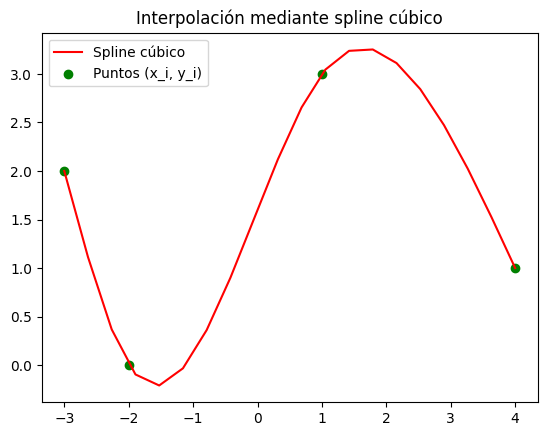

In [68]:
x_arr = np.linspace(-3, 4, 20)
plt.plot(x_arr, [spline.evaluate(x0) for x0 in x_arr], "red", label="Spline cúbico")
plt.scatter(x, y, label="Puntos (x_i, y_i)", c="green")
plt.legend()
plt.title("Interpolación mediante spline cúbico")
plt.show()

Dado que el spline cúbico es natural, debe cumplir que $S''(-3) = 0 = S''(4)$. Al evaluar la segunda derivada de spline en dichos puntos observamos que en efecto obtenemos 0. Recordar que si $x_i \leq x \leq x_{i+1}$, entonces $S''(x) = 2c_i + 6d_i(x-x_i).$

In [6]:
print("Valor de la segunda derivada del spline en x = -3:", spline.evaluate_snd_der(-3))
print("Valor de la segunda derivada del spline en x = 4:", spline.evaluate_snd_der(4))

Valor de la segunda derivada del spline en x = -3: 0.0
Valor de la segunda derivada del spline en x = 4: 2.220446049250313e-16


3.b) Usa el spline para calcular el valor en las posiciones $x = 0$ y $x = 2$.

In [7]:
print("Valor del spline en x=0:", spline.evaluate(0))
print("Valor del spline en x=2:", spline.evaluate(2))

Valor del spline en x=0: 1.598978288633461
Valor del spline en x=2: 3.1890166028097062


3.c) Compara el resultado previo con el obtenido usando otro polinomio interpolador. Discute los resultados.

Vamos a comparar la interpolación del spline cúbico con el polinomio de Newton (método de diferencias divididas). A continuación se construye una clase para calcular el polinomio de Newton y evaluarlo en un punto dado.

In [35]:
class PolinomioNewton:    
    """Clase para calcular y evaluar el polonomio interpolador de Newton mediante diferencias divididas f[x_0, x_1, ..., x_k].
    """    
    x: np.array # vector de puntos x_i (ordenado)
    y: np.array # vector de puntos y_i

    A: np.array # Vector con los coeficientes de las diferencias divididas f[x_0, x_1, ..., x_k]
    
    def __init__(self, x: np.array, y: np.array):
        """Inicialización de la clase que recibe los puntos (x_i, y_i) que se van a interpolar mediante el spline cúbico. El vector x se supone ordenado.

        :param x: Vector de puntos x_i
        :type x: np.array
        :param y: Vector de valores y_i
        :type y: np.array
        """      
        self.x = x
        self.y = y
    
    def fit(self) -> np.array:
        """Método para realizar la interpolación.

        :return: Vector con los coeficientes de las diferencias divididas f[x_0, x_1, ..., x_k] 
        :rtype: np.array
        """        
        # Obtiene los coeficientes del polinomio de Newton a través de diferencias divididas
        n = self.x.size
        F = np.zeros((n, n))
        
        F[0] = self.y
        
        for i in range(1, n):
            for j in range(i, n):
                F[i, j] = (F[i-1, j] - F[i-1, j-1])/(x[j] - x[j-i])
                
        self.A = np.diag(F)
                
        return self.A

    def evaluate(self, x0: float) -> float:
        """Método para evaluar el polinomio de Newton en un punto dado x0.

        :param x0: Punto en el que se quiere evaluar el polinomio.
        :type x0: float
        :return: Evaluación del polinomio en el punto x0.
        :rtype: float
        """        
        n = self.x.size
        
        prod = 1
        
        P = self.A[0]
        
        for i in range(1, n):
            prod = prod*(x0 - self.x[i-1])
            P = P + self.A[i]*prod
            
        return P

In [38]:
pol_newton = PolinomioNewton(x, y)
pol_newton.fit()

array([ 2.       , -2.       ,  0.75     , -0.1468254])

Gráfica del polinomio de Newton y el spline cúbico en el intervalo $[-3, 4]$:

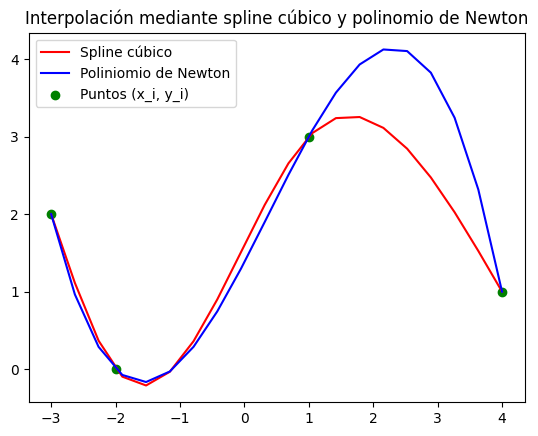

In [69]:
x_arr = np.linspace(-3, 4, 20)
plt.plot(x_arr, [spline.evaluate(x0) for x0 in x_arr], "red", label="Spline cúbico")
plt.plot(x_arr, [pol_newton.evaluate(x0) for x0 in x_arr], "blue", label="Poliniomio de Newton")
plt.scatter(x, y, c="green", label = "Puntos (x_i, y_i)")
plt.legend()
plt.title("Interpolación mediante spline cúbico y polinomio de Newton")
plt.show()

Se observa que el comportamiento del spline es más suave que el polinomio de Newton. Particularmente, en el intervalo $[1, 4]$ se observa que el polinomio de Newton tiene una oscilación muy pronunciada.

### Problema 4

La función $f(x)$ se conoce en los puntos $x_k$ dado en la tabla

| x | 0.0 | 0.25| 0.5 | 0.75 | 1.0 |
|:---: |:---:| :---: | :---: |:---:| :---: |
| f(x) | 1.000 | 1.015 | 1.006 | 0.882 | 0.670 |

Usa las fórmulas de Newton Cotes Trapezoidal y de Simpson para aproximar la integral
$$
\int_0^1 f(x)dx.
$$
Da una estimación del error en cada caso.

In [41]:
def IntegracionTrapecio(x: np.array, y: np.array) -> float:
    """Función para calcular la integral de una función mediante la regla del Trapecio. Esta función está dada por puntos x=[x_0, x_1, ..., x_n], equiespaciados y ordenados, y sus respectivas imágenes 
    y=[f(x_0), f(x_1), ..., f(x_n)]. Notar que cuando n = 2, se tiene la regla para integración simple, y para n > 3 se tiene la regla para integral compuesta.

    :param x: Puntos equiespaciados y ordenados x=[x_0, x_1, ..., x_n] en donde se evalúa la función f.
    :type x: np.array
    :param y: Imágenes de los puntos x=[x_0, x_1, ..., x_n] bajo f, i.e., y=[f(x_0), f(x_1), ..., f(x_n)]
    :type y: np.array
    :raises Exception: Se levanta una excepción si se reciben menos de 3 puntos.
    :return: Integral utilizando regla del Trapecio.
    :rtype: float
    """    
    if len(x) < 2:
        raise Exception("Se necesitan más de dos puntos.")
    
    h = x[1] - x[0]
    I = y[0] + y[-1] + 2*(y[1:-1].sum())
    I = I*h/2
    
    return I

def IntegracionSimpson(x: np.array, y: np.array) -> float:
    """Función para calcular la integral de una función mediante la regla de Simpson. Esta función está dada por puntos x=[x_0, x_1, ..., x_n], equiespaciados y ordenados, y sus respectivas imágenes 
    y=[f(x_0), f(x_1), ..., f(x_n)]. Notar que cuando n = 2, se tiene la regla para integración simple, y para n > 3 se tiene la regla para integral compuesta.

    :param x: Puntos equiespaciados y ordenados x=[x_0, x_1, ..., x_n] en donde se evalúa la función f.
    :type x: np.array
    :param y: Imágenes de los puntos x=[x_0, x_1, ..., x_n] bajo f, i.e., y=[f(x_0), f(x_1), ..., f(x_n)]
    :type y: np.array
    :raises Exception: Se levanta una excepción si se reciben menos de 3 puntos o si se tiene una cantidad par de puntos. Para la regla de Simpson se necesita una cantidad de puntos impar mayor o igual a 3.
    :return: Integral utilizando regla de Simpson.
    :rtype: float
    """    
    if len(x) < 3 or len(x) % 2 == 0:
        raise Exception("Se necesita una cantidad de puntos impar mayor o igual a 3 para este método.")
    
    h = x[1] - x[0]
    i = np.array(range(len(x)))
    I = y[0] + y[-1] + 2*(y[i % 2 == 0][1:-1].sum()) + 4*(y[i % 2 == 1].sum())
    I = I*h/3
    
    return I


Puntos de la función dados:

In [70]:
x = np.arange(0, 1.1, 0.25)
y = np.array([1, 1.015, 1.006, 0.882, 0.670])
x, y

(array([0.  , 0.25, 0.5 , 0.75, 1.  ]),
 array([1.   , 1.015, 1.006, 0.882, 0.67 ]))

Gráfica de los puntos $(x_i, y_i)$:

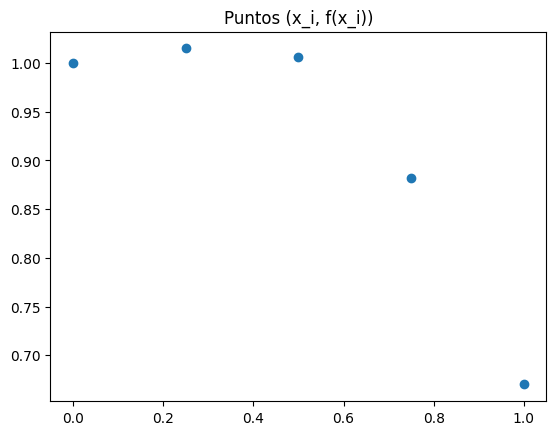

In [71]:
plt.scatter(x, y)
plt.title("Puntos (x_i, f(x_i))")
plt.show()

La integral $I = \int_0^1 f(x)dx$ aproximada con la regla del Trapecio y regla de Simpson:

In [46]:
print("Aproximación con regla del Trapecio:", IntegracionTrapecio(x, y))
print("Aproximación con regla de Simpson:", IntegracionSimpson(x, y))

Aproximación con regla del Trapecio: 0.9345
Aproximación con regla de Simpson: 0.9391666666666666


El error de la integración compuesta usando la regla del Trapecio está dado por 
$$
\int_a^b f(x)dx - I_T = - \frac{b-a}{12}h^2f''(\mu),
$$
para algún $\mu \in (a,b)$, donde $I_T$ es el valor de la integral compuesta usando la regla del Trapecio (ver Teorema 4.5, página 205, del Burden). Por otro lado, sabemos que 
$$
f''(x) \approx \frac{1}{h^2}(f(x+h) - 2f(x) + f(x-h)),
$$
para $h$ suficientemente pequeña. De manera que podemos obtener estimaciones para $f''(0.25), f''(0.5), f''(0.75)$, nuestro caso con $h=0.25$.

In [78]:
h = 0.25
a, b = 0, 1

f_snd_der = (y[2:] - 2*y[1:-1] + y[:-2])/(h**2)

print("f''(0.25) =", f_snd_der[0])
print("f''(0.5) =", f_snd_der[1])
print("f''(0.75) =", f_snd_der[2])

f''(0.25) = -0.3839999999999968
f''(0.5) = -1.8399999999999999
f''(0.75) = -1.4079999999999977


Viendo estos valores de $f''$, podemos estimar que $ 3 \geq \sup_{x\in [0, 1]} |f''(x)|$. Así, podemos obtener una estimación del error:
$$
\left| \int_0^1 f(x)dx - I_T \right| = \left| \frac{1}{12}h^2f''(\mu) \right| \leq \frac{3}{12}h^2 = 0.015625.
$$

In [80]:
print("Una estimación del error es:", (b-a)/12*(h**2)*3)

Una estimación del error es: 0.015625


El error de la integración compuesta usando la regla de Simpson está dado por
$$
\int_a^b f(x)dx - I_S  = -\frac{b-a}{180}h^4f^{(4)}(\mu),
$$
para algún $\mu\in (a,b)$, donde $I_S$ es el valor de la integral compuesta usando la regla de Simpson (ver Teorema 4.4, página 204, del Burden). En clase vimos que existe $\xi \in (a,b)$ tal que
$$
f[x_0, x_1, \ldots, x_k] = \frac{f^{(k)}(\xi)}{k!},
$$
por lo que podemos obtener $f^{(4)}(\xi) = 4!\cdot f[x_0, x_1, \ldots, x_4]$, que es el único valor de la cuarta derivada que podemos obtener de los datos.

In [81]:
# diferencias divididas
n = x.size
F = np.zeros((n, n)) # tabla de diferencias divididas

F[0] = y

# llenar tabla F
for i in range(1, n):
    for j in range(i, n):
        F[i, j] = (F[i-1, j] - F[i-1, j-1])/(x[j] - x[j-i])
        
dif_div = F[-1,-1] # f[x_0, x_1, x_2, x_3, x_4]

print("El único término de la cuarta derivada que podemos obtener de los datos es:", 24*dif_div)

El único término de la cuarta derivada que podemos obtener de los datos es: 30.208000000000112


Con esta observación, podemos estimar $\sup_{x\in [0,1]} |f^{(4)}(x)| \leq 35$. Así obtenemos una estimación del error:
$$
\left| \int_0^1 f(x)dx - I_S \right| = \frac{1}{180}h^4 |f^{(4)}(\mu)| \leq \frac{35}{180}h^4 = 0.0007595486.
$$

In [84]:
print("Una estimación del error es:", 35*(h**4)*(b-a)/180)

Una estimación del error es: 0.0007595486111111111


### Problema 5

Sea $f(x) = \cos(x^2)\sqrt{4-x}$. Se quiere integrar $f$ en el intervalo $[0,4]$. Grafiquemos $f$ en dicho intervalo para estudiar su comportamiento.

In [89]:
def f(x: float) -> float:
    return np.cos(x**2)*(4-x)**0.5

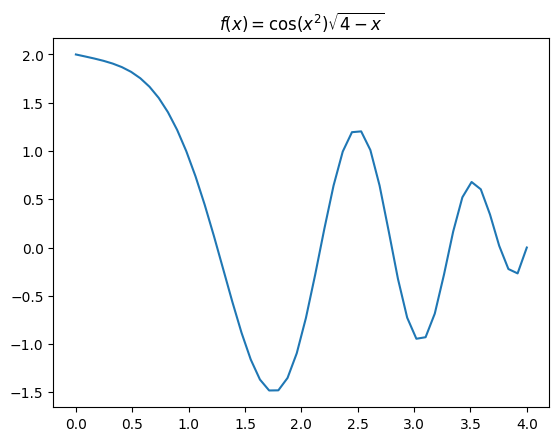

In [91]:
x_arr = np.linspace(0, 4, 50)
y_arr = np.array([f(x0) for x0 in x_arr])
plt.plot(x_arr, y_arr)
plt.title("$f(x) = \cos(x^2)\sqrt{4-x}$")
plt.show()

Observamos que $f$ tiene 3 crestas de ondas en el intervalo de interés. La integración con la regla del trapecio podría tener problemas si se trabaja con pocos puntos debido a estas oscilaciones. A continuación veremos la gráfica de los puntos $(n, I(n))$, donde $I(n)$ es la aproximación de la integral con regla del Trapecio usando $n$ puntos, para diferentes valores de $n$.

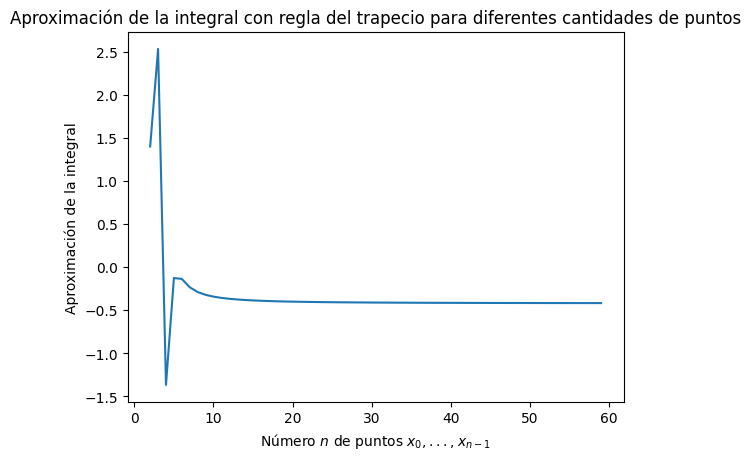

In [109]:
ns = range(2, 60)

def get_x_and_y(n):
    x_arr = np.linspace(1, 4, n)
    y_arr = np.array([f(x0) for x0 in x_arr])
    return x_arr, y_arr

plt.plot(ns, [IntegracionTrapecio(*get_x_and_y(n)) for n in ns])
plt.xlabel("Número $n$ de puntos $x_0, ..., x_{n-1}$")
plt.ylabel("Aproximación de la integral")
plt.title("Aproximación de la integral con regla del trapecio para diferentes cantidades de puntos")
plt.show()

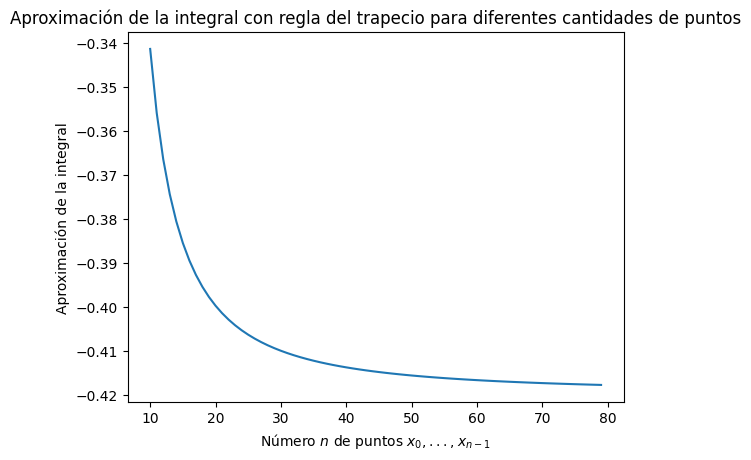

In [112]:
ns = range(10, 80)

def get_x_and_y(n):
    x_arr = np.linspace(1, 4, n)
    y_arr = np.array([f(x0) for x0 in x_arr])
    return x_arr, y_arr

plt.plot(ns, [IntegracionTrapecio(*get_x_and_y(n)) for n in ns])
plt.xlabel("Número $n$ de puntos $x_0, ..., x_{n-1}$")
plt.ylabel("Aproximación de la integral")
plt.title("Aproximación de la integral con regla del trapecio para diferentes cantidades de puntos")
plt.show()

Con esta gráfica observamos que $I(n)$ converge a un punto mientras va creciendo $n$. Para $n=80$ obtenemos una buena estimación de la integral:

In [113]:
IntegracionTrapecio(*get_x_and_y(80))

-0.4177177875083176

Veamos la aproximación de la integral ahora usando cuadratura Gaussiana. Sabemos que podemos escoger $x_1, \ldots, x_n$ y $c_1, \ldots, c_n$ tales que 
$$
\int_{-1}^1 f(x)dx \approx \sum_{i=1}^n c_i\, f(x_i).
$$
Los $x_1, \ldots, x_n\in [-1, 1]$ se pueden tomar como los ceros del $n$-ésimo polinomio de Legendre, y 
$$
c_i = \int_{-1}^1 \prod_{\substack{j=1, \\ j\neq i}}^n \frac{x-x_j}{x_i-x_j}dx
$$
(ver Teorema 4.7, página 231, del Burden). Mediante un cambio de variable, podemos calcular la integral de $f$ en un intervalo arbitrario:
$$
\int_a^b f(x)dx = \frac{b-a}{2} \int_{-1}^1 f\left( \frac{(b-a)t + (b-a)}{2} \right)dt \approx \frac{b-a}{2}\sum_{i=1}^n c_i\, f\left( \frac{(b-a)x_i + (b-a)}{2} \right).
$$

In [115]:
def GaussianQuadrature(f: Callable[[float], float], a: float, b: float, n: int) -> float:
    """Función para integrar una función f en [a, b] utilizando el método de cuadratura Gaussiana.

    :param f: Función a integrar (recibe un flotante y regresa un flotante).
    :type f: Callable[[float], float]
    :param a: Extremo izquierdo del intervalo de integración.
    :type a: float
    :param b: Extremo derecho del intervalo de integración.
    :type b: float
    :param n: Número de nodos a usar en la cuadratura Gaussiana.
    :type n: int
    :return: Estimación de la integral
    :rtype: float
    """
    
    roots, w = np.polynomial.legendre.leggauss(n) # función que regresa los nodos y los pesos de la cuadratura Gaussiana (los nodos son las raíces del n-ésimo polinomio de Legendre)
    
    def change_variable(t: float) -> float:
        return ((b-a)*t + (b+a))/2
     
    return (b-a)/2*(np.array([w[i]*f(change_variable(roots[i])) for i in range(n)]).sum())

A continuación veremos la gráfica de los puntos $(n, I_G(n))$, donde $I_G(n)$ es la aproximación de la integral con cuadratura Gaussiana usando $n$ puntos, para diferentes valores de $n$.

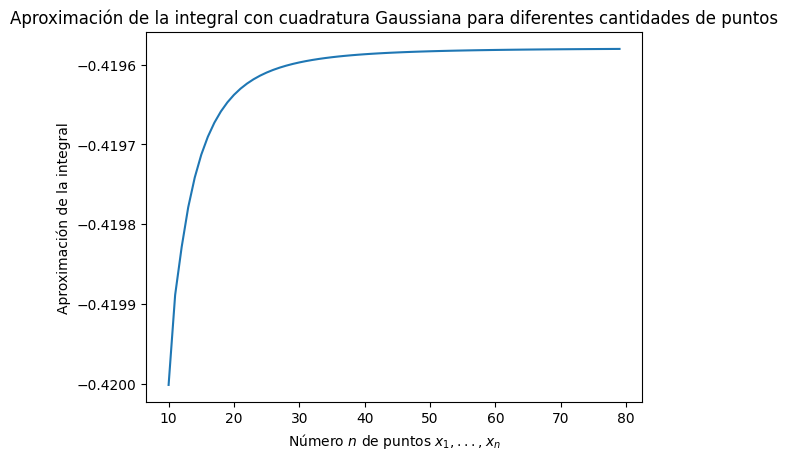

In [121]:
ns = range(10, 80)
plt.plot(ns, [GaussianQuadrature(f, 1, 4, n) for n in ns])
plt.xlabel("Número $n$ de puntos $x_1, ..., x_{n}$")
plt.ylabel("Aproximación de la integral")
plt.title("Aproximación de la integral con cuadratura Gaussiana para diferentes cantidades de puntos")
plt.show()

Con esta gráfica observamos que $I(n)$ converge a un punto mientras va creciendo $n$. Para $n=60$ obtenemos una buena estimación de la integral:

In [124]:
GaussianQuadrature(f, 1, 4, 60)

-0.41958175102878326

Que es un valor muy parecido a la aproximación que obtuvimos con la regla del trapecio:

In [119]:
IntegracionTrapecio(*get_x_and_y(80))

-0.4177177875083176